# Dependency tree via autonomous categories
> see
> - https://ncatlab.org/nlab/show/dependency+grammar
> - https://arxiv.org/pdf/1411.3827.pdf
> 
> for relevant theory

In [1]:
import spacy; nlp = spacy.load("en_core_web_sm")

tree_doc = nlp("This is my dependency tree!")
sentence = next(tree_doc.sents)

sentence2 = next(nlp("The quick brown fox jumps over the lazy dog.").sents)

# Step 1 - Cups only, "≤" boxes
- word order is kept track of by (invisible) input wires to words at the top of the diagram

#### ≤ Boxes:
- when a word has children in the dependency tree, it is connected to the input of a "≤" box:
    - one output wire of the same grammatical type to connect to either an ancestor in the tree or to diagram output
    - dependent children to left in sentence connected by right adjoint output wires
    - dependent children to right connected by left adjoint output wires
- leaves of the tree are just words
- dependency structure encoded in cups

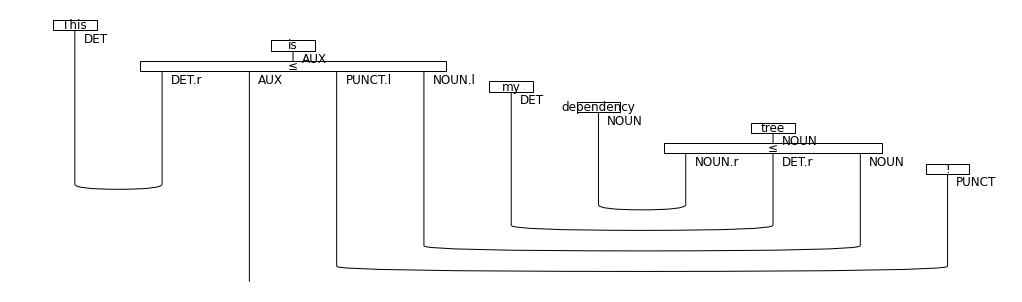

In [2]:
from discopy import Ty, Word, Id, Box
from discopy.grammar import eager_parse

def autonomous_tree_nocaps(sentence):
    
    def _inner(token):
        # base case
        if token.n_lefts + token.n_rights == 0:
            return Word(token.text, Ty(token.pos_))

        # else build left and right dependent subtrees
        left_cod = Ty()
        right_cod = Ty()
        layer = []

        # keep track of number of left dependent subtrees for 'leq' box insertion at end
        n_lefts = 0

        for child in token.lefts:
            layer.append(_inner(child))
            n_lefts += 1
            left_cod = Ty(child.pos_).r @ left_cod
        for child in token.rights:
            layer.append(_inner(child))
            right_cod = Ty(child.pos_).l @ right_cod

        cod = left_cod @ Ty(token.pos_) @ right_cod

        # insert 'leq' box between left and right subtrees
        layer.insert(n_lefts, (Word(token.text, Ty(token.pos_)) >> Box('≤', Ty(token.pos_), cod)))
        # tensor subtrees and 'leq' box together, in correct order
        layer = Id(Ty()).tensor(*layer)

        return layer
    
    return eager_parse(_inner(sentence.root), target=Ty(sentence.root.pos_))

diagram = autonomous_tree_nocaps(sentence)
diagram.draw(figsize=(14,4))

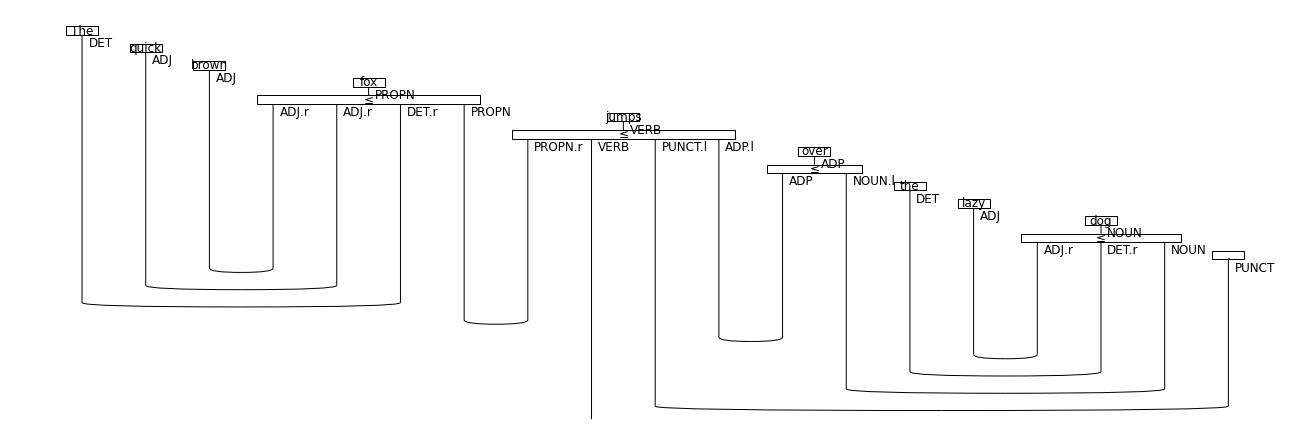

In [3]:
diagram2 = autonomous_tree_nocaps(sentence2)
diagram2.draw(figsize=(18,6))

# Step 2 - Functor to add caps 
To follow the construction in https://arxiv.org/pdf/1411.3827.pdf (figure 1). The arrow mapping is defined by `add_caps_box`

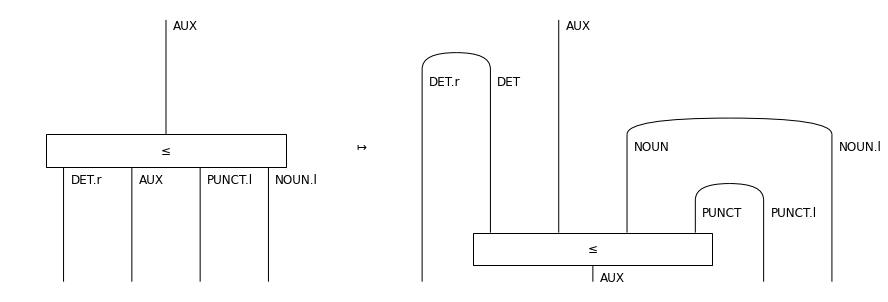

In [4]:
from discopy import Cup, Cap, Functor, drawing

def add_caps_box(box):
    left = Id(Ty())
    right = Id(Ty())
    dom = Ty()
    rdom = Ty()
    cod = Ty()
    l = None
    m = Id(Ty())
    r = None
    for i, obj in enumerate(box.cod):
        if obj.z == 1:
            dom = Ty(obj.name) @ dom
            left = left @ Id(Ty(obj.name).r)
            if not l:
                l = Cap(Ty(obj.name).r, Ty(obj.name))
            else:
                l =  l >> Id(box.cod[:i]) @ Cap(Ty(obj.name).r, Ty(obj.name)) @ Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[:i].objects]))
        elif obj.z == 0:
            dom = dom @ Ty(obj.name)
            cod = cod @ Ty(obj.name)
            m = m @ Id(Ty(obj.name))
        elif obj.z == -1:
            rdom = Ty(obj.name) @ rdom
            right = right @ Id(Ty(obj.name).l)
            if not r:
                r =  Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[i+1:].objects])) @ Id(box.cod[i+1:])\
                >> Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[i+1:].objects])) @ Cap(Ty(obj.name), Ty(obj.name).l) @ Id(box.cod[i+1:])
            else:
                r = Id(Ty()).tensor(*reversed([Id(Ty(obj.name)) for obj in box.cod[i+1:].objects])) @ Cap(Ty(obj.name), Ty(obj.name).l) @ Id(box.cod[i+1:]) >> r
    
    dom = dom @ rdom
    full = m
    if l: full = l @ full
    if r: full = full @ r
    if box.name == '≤':
        full = full >> (left @ Box('≤', dom, cod) @ right)
    else:
        full = box >> full

    return full

box = diagram.boxes[2]
drawing.equation(box, add_caps_box(box), symbol="$\mapsto$", figsize=(12,4))

# Step 3 - Apply functor, followed by snake removal

- object mapping is given by the identity map (spaCy types to spaCy types)

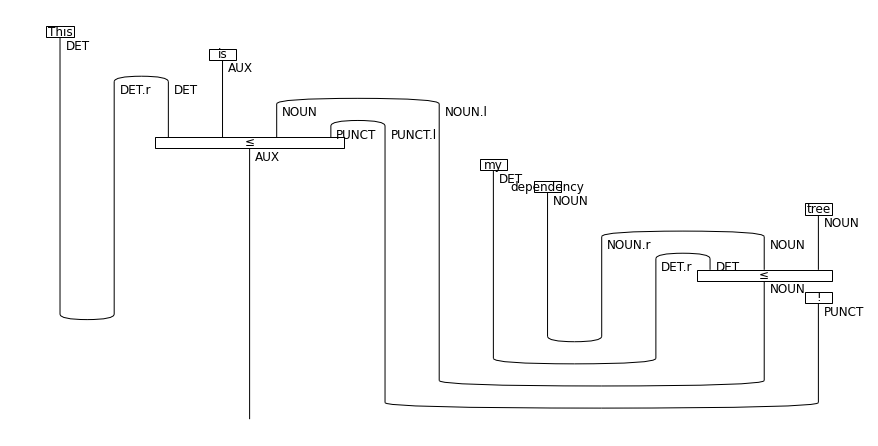

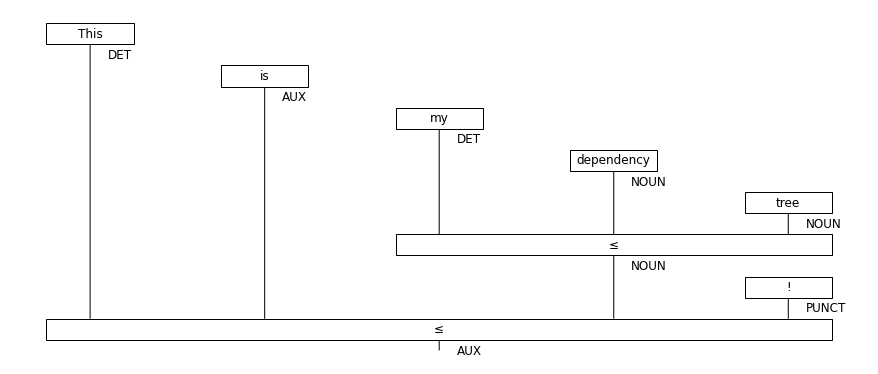

In [5]:
from discopy import Diagram

spacy_types = [
Ty('ADJ'),
Ty('ADP'),
Ty('ADV'),
Ty('AUX'),
Ty('CONJ'),
Ty('DET'),
Ty('INTJ'),
Ty('NOUN'),
Ty('NUM'),
Ty('PART'),
Ty('PRON'),
Ty('PROPN'),
Ty('PUNCT'),
Ty('SCONJ'),
Ty('SYM'),
Ty('VERB'),
Ty('X'),
Ty('SPACE'),
Ty('CCONJ')
]

ob = {ty: ty for ty in spacy_types}
add_caps_functor = Functor(ob, ar=add_caps_box, ob_factory=Ty, ar_factory=Diagram)

snakey = add_caps_functor(diagram)
snakey.draw(figsize=(12,6))
snakey.normal_form().draw(figsize=(12,5))

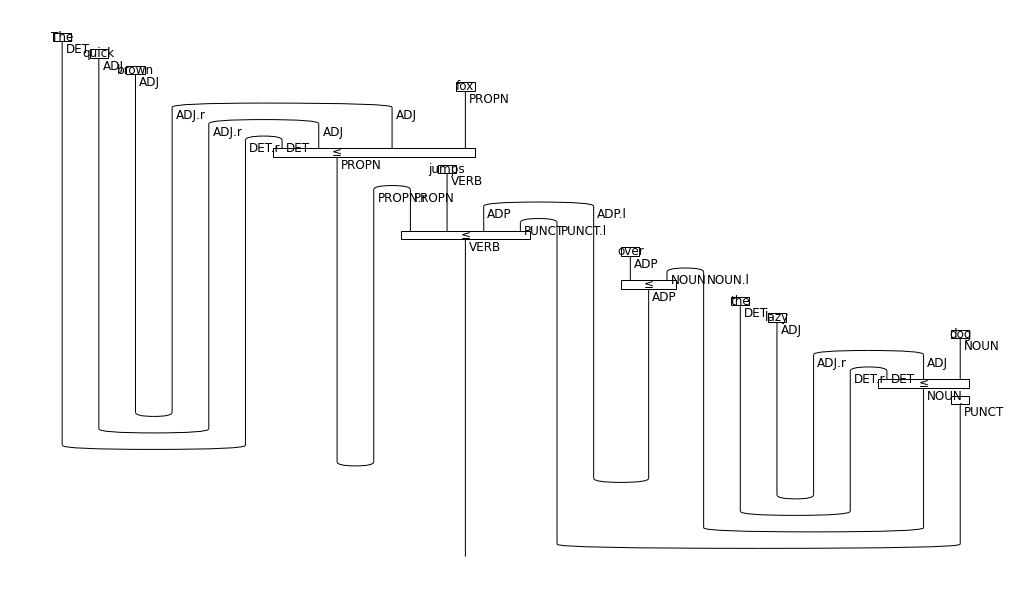

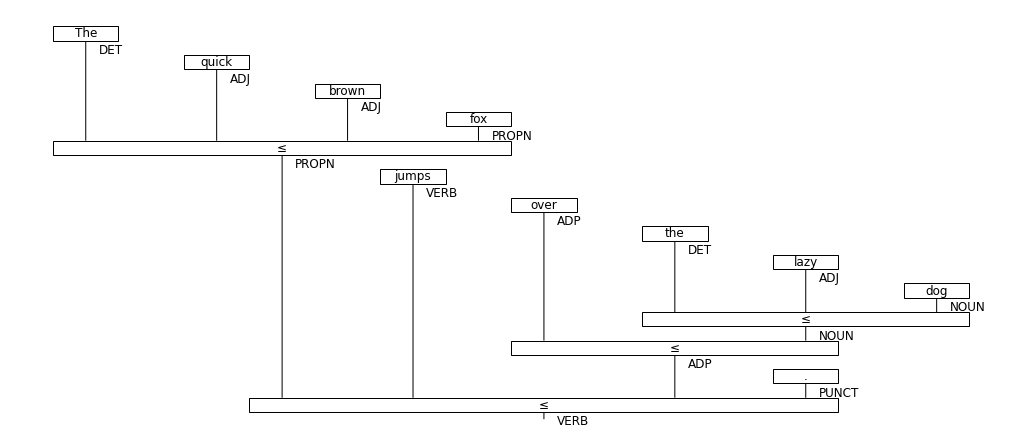

In [6]:
snakey2 = add_caps_functor(diagram2)
snakey2.draw(figsize=(14,8))
snakey2.normal_form().draw(figsize=(14,6))